# Phase 2 Final Project

* Student name: Caroline Surratt
* Student pace: Self-Paced
* Scheduled project review date/time: Wednesday, August 23rd at 3:00 PM
* Instructor name: Morgan Jones

# Business Understanding

This analysis was conducted for a company that is interested in creating original video content. However, the company lacks insight as to what types of films are currently performing best at the box office. This analysis seeks to understand patterns and trends in movie performance in order to recommend what types of films the company should produce to maximize profit. 

For the purpose of this analysis, movie performance will be evaluated using **percent return on investment**. 



\begin{align}
\text{Percent Return} = \frac{\text{total gross revenue – production budget}}{\text{production budget}}*100
\end{align}


This feature will provide more insight than evaluating **total gross revenue** alone since it takes into consideration the size of the initial investment (in this case, the budget to produce the film).

While other factors (consumer ratings, critic reviews, etc.) may be meaningful in the context of analyzing film as an art form, this company is not necessarily interested in producing Academy-Award-winning films. Rather, they are concerned with earning a profit and maximizing their investments in the new movie studio.

In order to better understand what types of films are performing best, I will examine the relationships between percent return and movie characteristics, including production budget, genre, and runtime.

# Data Understanding

Two datasets were used for this analysis.

The first dataset is from The Numbers. This dataset contains information about nearly 6,000 film budgets and revenues from 1915-2020, with most entries falling between the years 2000-2012. This dataset is stored in this repository as a compressed CSV file.

The second dataset is from IMDB. This dataset is a SQLite database with information about over 146,000 movies, including information about each movie's length, when it was released, and its genre. This database also contains information about actors/actresses, directors, and writers, as well as which films they are associated with.

While there are significantly more entries in the IMDB dataset, this information will not be useful to the company without additional information about the profitability of the movie. Therefore, only entries in IMBD that have a corresponding entry in The Numbers dataset will be considered.

# Importing Libraries and Data

First, I will import the libraries and packages necessary for this analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

# turned off chained assignment warning, as I was receiving false positive warnings
pd.options.mode.chained_assignment = None

### The Numbers Dataset

Now, I will import the dataset from The Numbers and preview the DataFrame.

In [2]:
numbers = pd.read_csv("data/tn.movie_budgets.csv.gz")
numbers

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0


In [3]:
numbers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


This dataset contains information about the budgets and revenues of nearly 6,000 movies, with no missing entries. Before much of the data can be utilized, the numbers must be converted to integers instead of objects. 

For the columns with currency values, I will remove the $ symbol and commas in order to convert these values to a usable type.

For the column with dates, I will adjust the entires so that only contain the year (as an integer). Since the IMDB table only contains the release year, this is the only information necessary. This way, the column can be used to match movies to their corresponding entries across the two datasets.

In [4]:
# created a list of the columns that are referring to a currency
currency_columns = ['production_budget', 'domestic_gross', 'worldwide_gross']

# used a for loop to remove '$' and ',' symbols from the entries in these columns and convert the remaining
# characters to integers instead of strings
for column in currency_columns:
    numbers[column] = numbers[column].str.replace("$", "")
    numbers[column] = numbers[column].str.replace(",", "")
    numbers[column] = numbers[column].astype(int)

# used a labmda function to select only the year from the release_date column and dropped the column with entire date
numbers['release_year'] = numbers['release_date'].map(lambda x: int(x[-4:]))
numbers.drop('release_date', axis=1, inplace=True)

Now that the columns with numeric values are of a numeric type, we can take a look at the descriptive statistics for this dataset, beginning with the release year.

In [5]:
numbers['release_year'].describe()

count    5782.000000
mean     2003.967139
std        12.724386
min      1915.000000
25%      2000.000000
50%      2007.000000
75%      2012.000000
max      2020.000000
Name: release_year, dtype: float64

This dataset contains entries about movies that were released as early as 1915. Because the company is interested in films that are currently doing well and film trends have changed significantly in the last century, I will limit this analysis to films that were produced in the 21st century (the year 2000 or later). This will still leave a substantial portion (over 75%) of the dataset for us to work with.

In [6]:
numbers = numbers.loc[numbers['release_year'] >= 2000]

### IMDB Dataset

In order to better understand the features of these movies and evaluate trends and patterns in the data, we will need to incorporate additional information from the IMDB file. In the cell below, I will connect to the IMDB file using SQLite 3. Then, I will merge the IMDB data with the data from The Numbers. Entries that have insufficient information will not be useful to this analysis: therefore, an inner merge will be used.

In [7]:
# The lines below are commented out to avoid running multiple times.
    # from zipfile import ZipFile
    # with ZipFile("data/im.db.zip", 'r') as zObject:
        #z Object.extractall(path="data/im.db")

# established connection to the database    
conn = sqlite3.connect("data/im.db/im.db")

# created a table called imdb by querying the title, year, runtime, and genres for each movie
imdb = pd.read_sql("""
SELECT original_title, 
       start_year, 
       runtime_minutes,
       genres
FROM movie_basics;""", conn)

# closed the connection to the database
conn.close()

In [8]:
# combined the numbers and imdb tables using an inner merge
# merged on both the title and the year so to avoid issues with repeat title names

movies = numbers.merge(imdb, how='inner', left_on=['movie', 'release_year'], 
                       right_on=['original_title', 'start_year'])

# Exploratory Analysis

Before analyzing movie performance by feature, I will explore the descriptive statistics for the dataset as a whole.

In [9]:
movies.describe()

,id,production_budget,domestic_gross,worldwide_gross,release_year,start_year,runtime_minutes
count,1533.000000,1.533000e+03,1.533000e+03,1.533000e+03,1533.000000,1533.000000,1508.000000
mean,50.504892,4.397901e+07,5.473294e+07,1.371262e+08,2013.893673,2013.893673,106.932361
std,28.749767,5.548813e+07,8.274126e+07,2.275636e+08,2.596904,2.596904,18.836937
min,1.000000,1.500000e+04,0.000000e+00,0.000000e+00,2010.000000,2010.000000,5.000000
25%,25.000000,7.500000e+06,2.483472e+06,7.482387e+06,2012.000000,2012.000000,94.000000
50%,51.000000,2.200000e+07,2.683950e+07,5.044586e+07,2014.000000,2014.000000,105.000000
75%,75.000000,5.500000e+07,6.638066e+07,1.525669e+08,2016.000000,2016.000000,118.000000
max,100.000000,4.106000e+08,7.000596e+08,2.048134e+09,2020.000000,2020.000000,189.000000


Now, we have a set of 1,533 movies produced since 2000 for which we have information about the production budget, revenue, release year, runtime, and genre.

The statistics show that on average, these films each cost approximately \\$44,000,000 to produce, and on average, they each brought in approximately \\$137,000,000 in worldwide gross revenue.

In order to better understand the relationship between these two variables, I will create a scatterplot below.

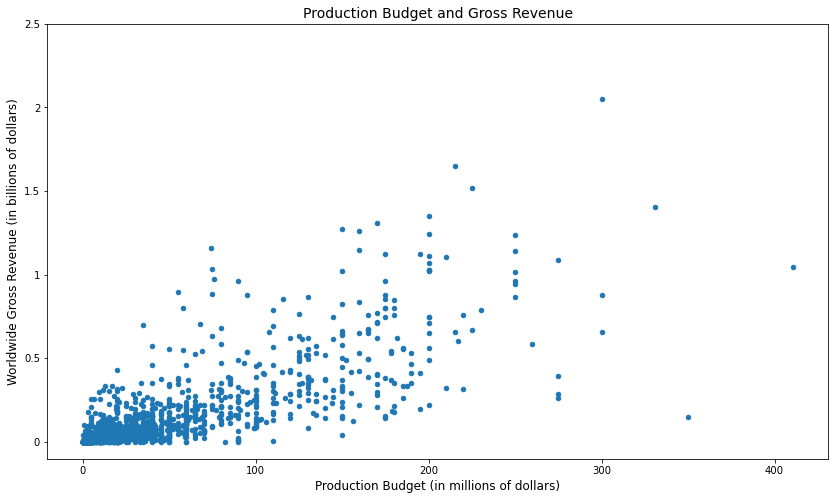

In [10]:
# created a subplot
fig, ax = plt.subplots(figsize=(14,8))

# created a scatterplot for production budget vs. gross revenue
movies.plot.scatter(x="production_budget", y="worldwide_gross", ax=ax)
ax.set_title("Production Budget and Gross Revenue", fontsize=14)
ax.set_xlabel("Production Budget (in millions of dollars)", fontsize=12)
ax.set_xticks([0, 100000000, 200000000, 300000000, 400000000])
ax.set_xticklabels([0, 100, 200, 300, 400])
ax.set_ylabel("Worldwide Gross Revenue (in billions of dollars)", fontsize=12)
ax.set_yticks(ticks=[0, 500000000, 1000000000, 1500000000, 2000000000, 2500000000])
ax.set_yticklabels(labels=[0, 0.5, 1, 1.5, 2, 2.5]);

Although this relationship is not linear and does not meet the criteria for performing a linear regression, there does appear to be somewhat of a weak relationship between budget and revenue: films with larger budgets tend to have larger revenues. 

### Percent Return

Looking at total gross revenue will give us some sense of what types of films perform best overall, but it will be more useful to analyze a feature that considers the relationship between revenue and production budget. Therefore, I will create a new column called **"%_return"** that gives the gross revenue as a percentage of the production budget. This feature will provide more insight than evaluating **total gross revenue** alone since it takes into consideration the size of the initial investment (in this case, the budget to produce the film).

The formula used can be seen in the cell below. 

\begin{align}
\text{Percent Return} = \frac{\text{total gross revenue – production budget}}{\text{production budget}}*100
\end{align}

In [11]:
# percent return = (earnings - cost) / cost
movies['%_return'] = (movies['worldwide_gross']-movies['production_budget'])/movies['production_budget']*100

Now, I will  sort the dataframe by this column so that the most profitable films are easily accessible.

In [12]:
movies.sort_values(by=['%_return'], ascending=False, inplace=True)
movies['%_return'].describe()

count     1533.000000
mean       268.521026
std       1196.362922
min       -100.000000
25%        -28.672900
50%        109.461378
75%        294.571910
max      41556.474000
Name: %_return, dtype: float64

On average, movies in this datset earned a 269% return on their initial investment (that is, approximately 2.5 times what was spent to produce the film). The film with the highest percent return had a whopping 41,556% return on investment! The lowest films had a -100% return (that is, no money was earned from the film, so the entire initial investment was lost).

Again, because **percent return** explains the extent to which the company will be able to profit off of its investments as a proportion (rather than an amount), this feature (rather than total gross revenue) will be the **feature analyzed in order to consider films "highly successful".**

For the remainder of this analysis, "top films", "highly profitable films", and "most successful films" will be used to refer to the **30 films with the highest percent returns**. This sample size will be large enough to draw meaningful conclusions while still only considering films that significantly outperformed the average of the dataset.

# Analysis by Production Budget

I will begin by creating a scatterplot showing the relationship between production budget and percent return.

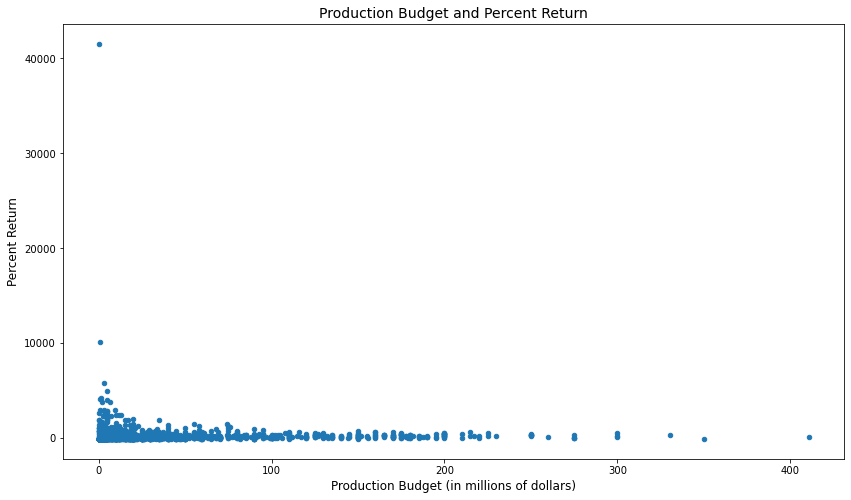

In [13]:
# created a subplot
fig, ax = plt.subplots(figsize=(14,8))

# created a scatterplot for production budget vs. percent return
movies.plot.scatter(x="production_budget", y="%_return", ax=ax)
ax.set_title("Production Budget and Percent Return", fontsize=14)
ax.set_xlabel("Production Budget (in millions of dollars)", fontsize=12)
ax.set_xticks([0, 100000000, 200000000, 300000000, 400000000])
ax.set_xticklabels([0, 100, 200, 300, 400])
ax.set_ylabel("Percent Return", fontsize=12);

Interestingly, the films with the highest percent returns have some of the lowest budgets. These films will be of particular interest to the company, as they demonstrate opportunities to generate impressive returns on investments. However, this visualization is somewhat difficult to interpret, since the two extreme values (the films with returns of approximately 40,000% and 10,000%) significantly affect the y-axis.

In the cell below, I will drop these two extreme values in order to better visualize the relationship for the rest of the data. _**These values will not be dropped from the dataset used for analysis - they are simply being temporariily ignored in order to improve the visualization.**_

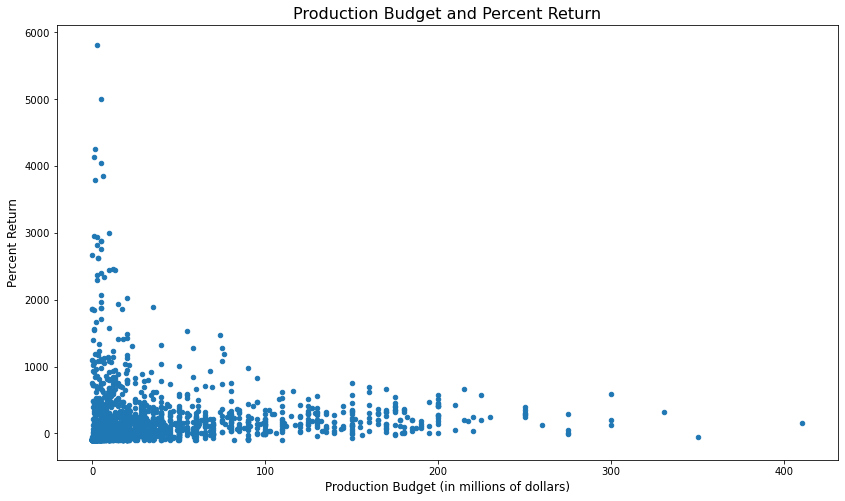

In [14]:
# created a subset of the movies dataframe that does not contain the extreme values 
movies_without_top_two = movies.loc[movies['%_return'] < 10000]

# created a new scatterplot using the subset
fig, ax = plt.subplots(figsize=(14,8))

movies_without_top_two.plot.scatter(x="production_budget", y="%_return", ax=ax)
ax.set_title("Production Budget and Percent Return", fontsize=16)
ax.set_xlabel("Production Budget (in millions of dollars)", fontsize=12)
ax.set_xticks([0, 100000000, 200000000, 300000000, 400000000])
ax.set_xticklabels([0, 100, 200, 300, 400])
ax.set_ylabel("Percent Return", fontsize=12);

Now, we can more clearly see the relationship between production budget and percent return. This relationship is still clearly nonlinear, but it is more obvious that the films with the highest percent returns have budgets that are less than \\$100 million.

In order to better understand this relationship, I will bin the data according to percent return and examine the budget using the function below.

In [29]:
# created a function that takes one input: the number (n) of top films to consider

def calculate_production_budget(n):
    
    #takes the top n films from the original dataframe
    top_n = movies.head(n)
    
    #calculates the mean production budget of these top films
    production_budget = top_n['production_budget'].mean()
    
    #prints the mean budget as well as the number of films considered, rounded to the nearest dollar
    print("The production budget for the ", n, " films with the highest percent return is $", 
          int(production_budget), ".")
    
for n in 5, 30, 50, 100, 250, 500:
    calculate_production_budget(n)

The production budget for the  5  films with the highest percent return is $ 2120000 .
The production budget for the  30  films with the highest percent return is $ 5360000 .
The production budget for the  50  films with the highest percent return is $ 8980000 .
The production budget for the  100  films with the highest percent return is $ 14752126 .
The production budget for the  250  films with the highest percent return is $ 32703130 .
The production budget for the  500  films with the highest percent return is $ 51307315 .


Again, there is not a linear relationship between the production budget and the percent return, but average production budgets produced above illustrate the following: The films that earn the most money per dollar (that is, the films that have the highest return on investment) have lower budgets, on average, than other films.

This led me to question: Are the budgets of these highly profitable movies different from the budgets of all other movies?

In [30]:
# defined a subset of the 30 movies with the highest percent returns
subset = movies.head(30)

# examined the descriptive statistics of the subset
subset.describe()

,id,production_budget,domestic_gross,worldwide_gross,release_year,start_year,runtime_minutes,%_return
count,30.00000,3.000000e+01,3.000000e+01,3.000000e+01,30.000000,30.000000,30.000000,30.000000
mean,56.10000,5.360000e+06,6.871923e+07,1.538556e+08,2014.266667,2014.266667,100.933333,4514.323223
std,25.09616,4.670199e+06,4.484561e+07,1.058622e+08,2.598850,2.598850,17.896124,7173.433735
min,2.00000,1.000000e+05,1.594798e+06,2.769782e+06,2010.000000,2010.000000,81.000000,1935.899100
25%,46.75000,2.625000e+06,4.112852e+07,7.741338e+07,2012.000000,2012.000000,87.250000,2412.205265
50%,58.50000,5.000000e+06,6.007848e+07,1.166483e+08,2014.500000,2014.500000,97.500000,2790.310037
75%,68.50000,6.125000e+06,9.775738e+07,2.429355e+08,2016.000000,2016.000000,109.750000,3838.329312
max,92.00000,2.000000e+07,1.760407e+08,4.263512e+08,2018.000000,2018.000000,161.000000,41556.474000


On average, these top 30 movies have a production budget of \\$5,360,000, which is much lower than the average budget for all movies (approximately \\$44,000,000). 

Is this difference statistially significant?

In order to examine this question, I will define highly profitable movies to be the 30 movies with the highest percent return on investment, and I will use a t-test with a standard alpha level of 0.05. 

**Null hypothesis**: Highly profitable movies have the same or higher production budgets compared to all movies.

**Alternative hypothesis**: Highly profitable movies have lower production budgets than all movies.

In [31]:
# converted the budget feature of the subset to a NumPy array
sample = subset['production_budget'].to_numpy()

# defined the population mean as the mean production movie of all movies
mu = numbers['production_budget'].mean()

# ran a 1 sample t-test to compare this subset (the sample) to the population of all movies
t_stat, p_value = stats.ttest_1samp(a=sample, popmean=mu)

# divided the resulting p_value by 2 since the stats 1-sample t-test assumes a two-sided test
print(p_value/2)

2.7546499574574263e-25


Using the t-statistic and p-value calculated above, we can **reject the null hypothesis** at the standard alpha level of 0.05: it is extremely unlikely that highly profitable movies have the same or higher production budgets than all movies. Highly profitable movies have lower production budgets than all movies.

The graph below illustrates the distribution of all films and highly profitable films by budget.

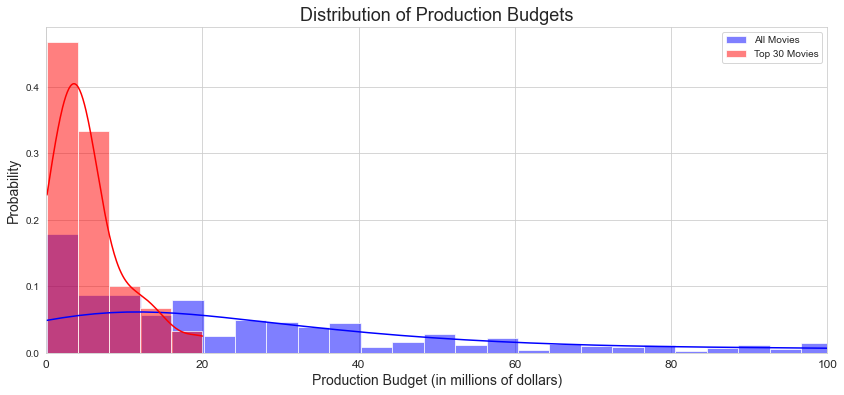

In [34]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(14,6))

# created a histogram (with the kde plot) for all movies in blue
sns.histplot(movies['production_budget'], kde=True, bins=102, \
             stat='probability', alpha=0.5, ax=ax, color='blue', label ="All Movies")

# created a histogram (with the kde plot) for the top 30 movies in red
sns.histplot(subset['production_budget'], kde=True, bins=5, \
             stat='probability', alpha=0.5, ax=ax, color='red', label="Top 30 Movies")

# limited x-axis to make visualization more readable
plt.xlim(-10, 100000000)

# adjusted x-axis ticks/labels to avoid scientific notation
plt.xticks(ticks=[0, 20000000, 40000000, 60000000, 80000000, 100000000], 
           labels=[0, 20, 40, 60, 80, 100],
          fontsize=12)

# set titles and labels
plt.title("Distribution of Production Budgets", fontsize=18)
plt.xlabel("Production Budget (in millions of dollars)", fontsize=14)
plt.ylabel("Probability", fontsize=14)

plt.legend();

In blue, we see that all films (denoted in blue) are slightly more concentrated between \\$0-20 million. However, this concentration is not nearly as substantial as the concentration of the 30 most profitable films. These films (denoted in red) are highly concentrated between \\$0-20 million, with the most concentration occurring between \\$0-8 million. No film in the subset has a budget of over \\$20 million. In contrast, the movie with the highest production budget exceeds \\$400 million - over 20 times that of the highest in the subset!

We cannot assume that the production budget *caused* these films to be more profitable. However, this difference in production budget is a statistically significant feature of highly profitable movies.

**Therefore, I recommend that the company mimic the production budgets of these highly profitable films and produce films with budgets of \\$8 or less.** The distribution of production budgets for this subset is not normally distributed, so a recommendation using a confidence interval is not appropriate. However, the distribution seen above illustrates that the majority of most profitable films have budgets of less than \\$8 million.

# Analysis by Genre

Analysis of movies by genre is not possible using the movies DataFrame in its current state because many of the movies have more than one genre listed in the 'genres' column. Therefore, running the .value_counts() function on this column will be insufficient, as this will return the unique combinations of movie genres and the number they appear as opposed to each unique genre and the number of times it appears. Refer to the cell below for additional context.

In [36]:
# demonstrated why running the .value_counts() function alone is insufficient
movies['genres'].value_counts()

Adventure,Animation,Comedy    68
Drama                         66
Comedy                        54
Comedy,Drama,Romance          52
Comedy,Drama                  49
                              ..
Documentary,Drama              1
Drama,Family,Music             1
Comedy,Drama,Sport             1
Action,Comedy,Documentary      1
Crime,Drama,History            1
Name: genres, Length: 233, dtype: int64

Although it may be possible to gain some information from these values, it will be more meaningful if we can extract the counts for individual genre in order to make a more

In [ ]:
all_genres = list(movies['genres'].value_counts().index)

In [ ]:
# https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists

def split_and_flatten(list):
    split_list = []
    for entry in list:
        split_list.append(entry.split(','))
    return set([item for sublist in split_list for item in sublist])

genres = split_and_flatten(all_genres)
genres

In [ ]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

def number_in_genre(genres_list):
    dataframes = []
    for genre in genres_list:
        q = """SELECT COUNT(*) 
               FROM movies 
               WHERE genres LIKE '%""" + genre + """%'"""
        df = pysqldf(q)
        df['genre'] = genre
        dataframes.append(df)
    return pd.concat(dataframes)

In [ ]:
all_movie_genres = number_in_genre(genres)

#extracted to numpy array for chi2 test
all_movie_genres_array = all_movie_genres['COUNT(*)'].to_numpy()

all_movie_genres.sort_values(by=["COUNT(*)"], inplace=True)
all_movie_genres

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

all_movie_genres.plot.barh(x='genre', y='COUNT(*)', label='All Movies', ax=ax)
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.title('Number of Movies by Genre', fontsize=15);

In [ ]:
top_30_movies = movies.head(30)

def number_in_genre(genres_list):
    dataframes = []
    for genre in genres_list:
        q = """SELECT COUNT(*) 
               FROM top_30_movies 
               WHERE genres LIKE '%""" + genre + """%'"""
        df = pysqldf(q)
        df['genre'] = genre
        dataframes.append(df)
    return pd.concat(dataframes)

top_movie_genres = number_in_genre(genres)
top_movie_genres_array = top_movie_genres['COUNT(*)'].to_numpy()
top_movie_genres

top_movie_genres.sort_values(by=["COUNT(*)"], inplace=True)
top_movie_genres

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

top_movie_genres.plot.barh(x='genre', y='COUNT(*)', label='Top 30 Movies', ax=ax)
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.title('Number of Movies by Genre', fontsize=15);

In [ ]:
for table in [all_movie_genres, top_movie_genres]:
    table['Percent of'] = table['COUNT(*)'].map(lambda x: x/(table['COUNT(*)'].sum()))
    table.drop('COUNT(*)', axis=1, inplace=True)

In [ ]:
all_movie_genres.rename(columns={'Percent of':'Percent of All Movies'}, inplace=True)
top_movie_genres.rename(columns={'Percent of':'Percent of Top 30 Movies'}, inplace=True)

In [ ]:
genre_comparison = all_movie_genres.merge(top_movie_genres, on='genre')
genre_comparison.sort_values(by=['Percent of Top 30 Movies'], ascending=True, inplace=True)

genre_comparison = genre_comparison.loc[genre_comparison['Percent of Top 30 Movies'] != 0]

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))

genre_comparison.plot(x='genre', y=['Percent of All Movies', 'Percent of Top 30 Movies'],
                     kind="barh", ax=ax)
plt.title("Percent of Movies by Genre");

In [ ]:
contingency_table = np.array([all_movie_genres_array,
                             top_movie_genres_array])
contingency_table

In [ ]:
stats.chi2_contingency(contingency_table)

The extremely low p-value here suggests that these two groups are performing differently.

## Analysis by Runtime

Next, I will explore the relationship between runtime and percent return. First, I will visualize the relationship with a scatterplot.

In [ ]:
fig, ax = plt.subplots()

plt.scatter(x=movies['runtime_minutes'], y=movies['%_return'])
plt.title("Runtime and Percent Return", fontsize=18)
plt.xlabel("Runtime (minutes)")
plt.ylabel("Percent Return");

There does not appear to be a clear relationship between movie runtime and percent return. However, it is clear that the two movies with the highest percent returns have similar runtimes - approximately 80-85 minutes. These two movies are so far above the others that they make the graph somewhat difficult to interpret, as they compress the y-axis significantly. In order to better visualize this relationship, I will drop the two most profitable movies and examine the remaining data points.

In [ ]:
movies_without_top_two = movies.loc[movies['%_return']<10000]

fig, ax = plt.subplots(figsize=(12,6))

plt.scatter(x=movies_without_top_two['runtime_minutes'], y=movies_without_top_two['%_return'])
plt.title("Runtime and Percent Return", fontsize=18)
plt.xlabel("Runtime (minutes)")
plt.ylabel("Percent Return");

Although there is not a linear relationship between these two variables, it does appear that many of the most profitable movies are clustered between 75-125 minutes. In order to better understand this relationship, I will bin the data according to percent return and analyze the runtime using the function below.

In [ ]:
def calculate_runtime(n):
    top_n = movies.head(n)
    runtime = top_n['runtime_minutes'].mean()
    print("The runtime for the ", n, " films with the highest percent return is", 
          int(runtime), "minutes.")
    
for n in 5, 30, 50, 100, 250, 500:
    calculate_runtime(n)

In [ ]:
movies['runtime_minutes'].mean()

In [ ]:
np.std(movies.runtime_minutes, ddof=1)

In [ ]:
subset = movies.head(30)
sample = subset['runtime_minutes'].to_numpy()
mu = movies['runtime_minutes'].mean()

In [ ]:
stats.ttest_1samp(a=sample, popmean=mu)

In [ ]:
print(subset.runtime_minutes.mean())
print(np.std(subset.runtime_minutes, ddof=1))
print(movies.runtime_minutes.mean())
print(np.std(movies.runtime_minutes))